## Exercise 3: Surge Pricing Schemas

### 1. Trip Length

The Exponential Distribution Model implies that short trips are most common, and the probability of a trip length decreases exponentially as the length increases.

- Realism: In ride-sharing, this assumption aligns with real-world data where the vast majority of rides are short commutes or last-mile connections (e.g., 2-5 miles), while very long trips (e.g., 20+ miles) are rare events.

- Memoryless Property: While less physically intuitive for trips, it simplifies the math. It implies that the probability of a trip continuing for another mile doesn't depend on how far it has already gone (though in reality, trips do have destinations). Ideally, a Log-Normal distribution might fit better, but Exponential is a standard simplifying assumption for these problems.

Sample Mean: 9.77 (Target: 10.00)


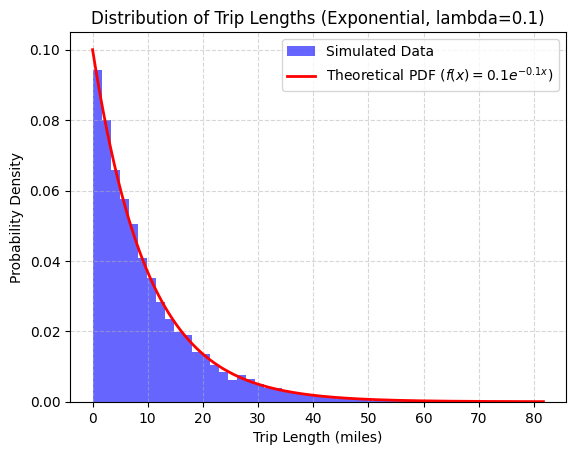

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter lambda = 0.1 (Mean = 10 miles)
lambd = 0.1
mean_trip = 1 / lambd

# Generate 10,000 random trip lengths
np.random.seed(42)
n_samples = 10000
trip_lengths = np.random.exponential(scale=mean_trip, size=n_samples)
count, bins, ignored = plt.hist(trip_lengths, bins=50, density=True, alpha=0.6, color='b', label='Simulated Data')

# Plot the theoretical PDF as baseline f(x) = lambda * exp(-lambda * x)
x = np.linspace(0, max(trip_lengths), 1000)
pdf = lambd * np.exp(-lambd * x)
plt.plot(x, pdf, linewidth=2, color='r', label='Theoretical PDF ($f(x) = 0.1 e^{-0.1x}$)')

plt.title('Distribution of Trip Lengths (Exponential, lambda=0.1)')
plt.xlabel('Trip Length (miles)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Sanity check
print(f"Sample Mean: {np.mean(trip_lengths):.2f} (Target: 10.00)")

### 2. Pricing Schemes

- In additive surge pricing, the payout is calculated as:
Payout = Base Fare + (Surge Multiplier − 1) × Surge Bonus,
where: Base Fare = c + r · x, c is a fixed fee, r is the per-unit cost, and x is the trip length. The surge bonus is a fixed amount added during surge periods.

- In multiplicative surge pricing
payout = Base Fare × Surge Multiplier

The implementation of above 2 payouts are shown as below.

For Mulplicative Surge Pricing: Mean Payout: $13.68, Variance: 134.61
For Additive Surge Pricing: Mean Payout: $11.74, Variance: 58.91


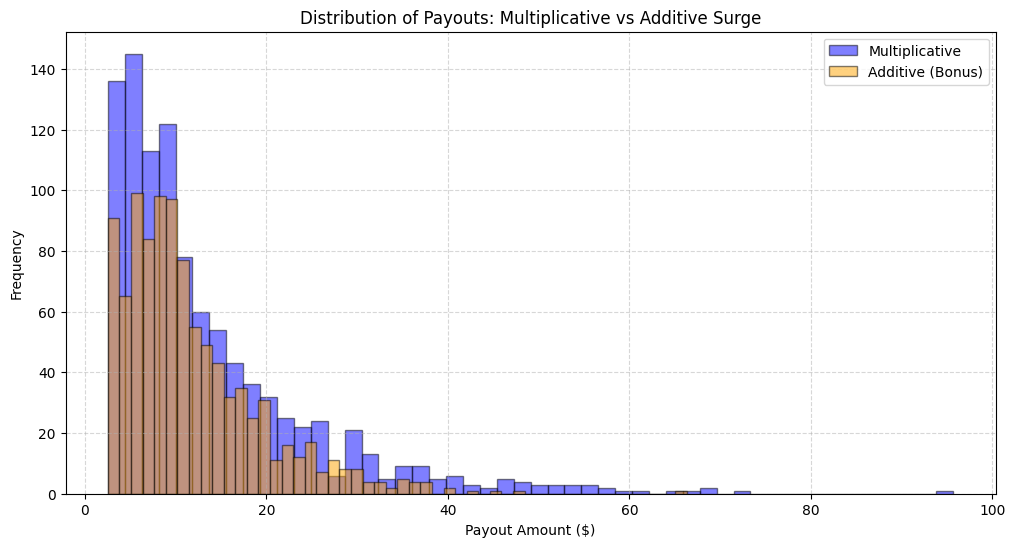

In [34]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n_trips = 1000

# 1. Generate Trip Length, Average 10 miles as above
lambd = 0.1
trip_lengths = np.random.exponential(scale=1/lambd, size=n_trips)

# 2. Generate Surge Multipliers with probability given
# Values: {1.0, 1.5, 2.0, 2.5}
# Probs:  {0.5, 0.3, 0.15, 0.05}
multipliers = np.random.choice(
    [1.0, 1.5, 2.0, 2.5], 
    size=n_trips, 
    p=[0.5, 0.3, 0.15, 0.05]
)

# 3. Additive Surge Parameters
c = 2.50      
r = 0.75    
surge_bonus = 5.00 

# Base Fare (Cost)
base_fares = c + r * trip_lengths

# Scheme A: Multiplicative Surge
payouts_mult = multipliers * base_fares

# Scheme B: Additive Surge (Bonus)
payouts_add = base_fares + (multipliers - 1) * surge_bonus

# Analysis mean and variance of each Schema
mean_mult = np.mean(payouts_mult)
var_mult = np.var(payouts_mult)

mean_add = np.mean(payouts_add)
var_add = np.var(payouts_add)

print(f"For Mulplicative Surge Pricing: Mean Payout: ${mean_mult:.2f}, Variance: {var_mult:.2f}")
print(f"For Additive Surge Pricing: Mean Payout: ${mean_add:.2f}, Variance: {var_add:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(payouts_mult, bins=50, alpha=0.5, label='Multiplicative', color='blue', edgecolor='black')
plt.hist(payouts_add, bins=50, alpha=0.5, label='Additive (Bonus)', color='orange', edgecolor='black')

plt.title('Distribution of Payouts: Multiplicative vs Additive Surge')
plt.xlabel('Payout Amount ($)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


According to the calculation above:

- For Mulplicative Surge Pricing: Mean Payout: $13.68, Variance: 134.61
- For Additive Surge Pricing: Mean Payout: $11.74, Variance: 58.91

This confirms the hypothesis: Multiplicative surge pricing introduces significantly higher variability into the driver's earnings (or passenger's cost) compared to a flat bonus scheme.

The mathematical reason:
- **Additive**: Adding a constant to a random variable ($X + C$) basically shifts the mean but keeps the spread (variance) similar. $Var(X+C) = Var(X)$. Even with a random bonus, the effect is additive.
- **Multiplicative**: Multiplying random variables ($K \cdot X$) compounds their variability. The formula involves the product of expectations and variances ($E[K^2]Var(X)...$), which drastically increases the total variance.

### 3. Driver Strategic Behavior.

a. In Multiplicative Surge Price, drivers are more likely to cherry-pick rides, since the variance is much higher, the difference in payout between long trip and short trip are significant. They will ignore short rides to wait for a long one.

b. Uber's Transition: Moving to Additive (Flat Bonus) fixes this. The difference between long and short trips are "smaller". A +$5 bonus is proportionally huge for a short trip (making it worth taking) but just a nice extra for a long trip. This levels the playing field and ensures short trips don't get rejected during busy times.

## Exercise 4

Consider a simplified ride-sharing platform with two zones (Zone A and Zone B) as discussed
in class. 



### 1. Optimize prices

Compare the profit of spatial pricing and uniform pricing.

From the result below, when spatial pricing, the total optimal profit is: $325.62 vs the profit for uniform price which is: $280.50. We get an increase of profite of 16% which shows spatial pricing can be benefitial.

Optimal Price Zone A: $5.50, Demand A at optimal price: 45.00, Optimal Revenue Zone A: $247.50
Optimal Price Zone B: $3.12, Demand B at optimal price: 25.00, Optimal Revenue Zone B: $78.12
Total Profit: $325.62
Optimal Price: $5.50, Demand at optimal price: 51.00, Total Profit: $280.50


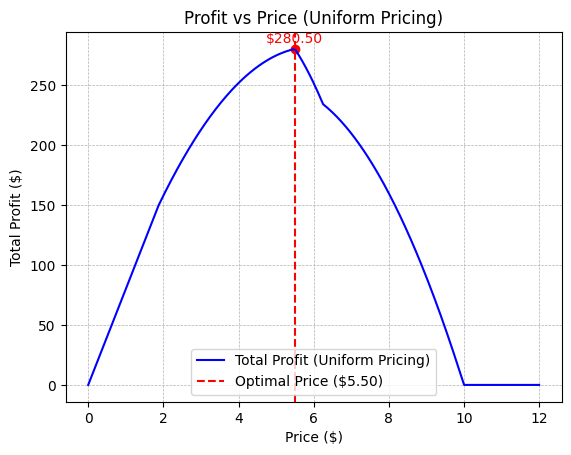

In [19]:
# The total profit function of all zones when using spatial pricing
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

def demand_A(p):
    return max(0, 100 - 10 * p)

def demand_B(p):
    return max(0, 50 - 8 * p)

supply_A = 45
supply_B = 35

# Objective functions for minimization (negative profit)
def neg_profit_A(p):
    d = demand_A(p)
    q = min(d, supply_A)
    return -(p * q)

def neg_profit_B(p):
    d = demand_B(p)
    q = min(d, supply_B)
    return -(p * q)

def optimize_spatial():
    # Optimize Zone A (Demand A becomes 0 at p=10)
    res_A = minimize_scalar(neg_profit_A, bounds=(0, 10), method='bounded')
    opt_p_A = res_A.x
    opt_rev_A = -res_A.fun
    
    # Optimize Zone B (Demand B becomes 0 at p=6.25)
    res_B = minimize_scalar(neg_profit_B, bounds=(0, 6.25), method='bounded')
    opt_p_B = res_B.x
    opt_rev_B = -res_B.fun
    
    total_profit = opt_rev_A + opt_rev_B

    print(f"Optimal Price Zone A: ${opt_p_A:.2f}, Demand A at optimal price: {demand_A(opt_p_A):.2f}, Optimal Revenue Zone A: ${opt_rev_A:.2f}")
    print(f"Optimal Price Zone B: ${opt_p_B:.2f}, Demand B at optimal price: {demand_B(opt_p_B):.2f}, Optimal Revenue Zone B: ${opt_rev_B:.2f}")
    print(f"Total Profit: ${total_profit:.2f}")

optimize_spatial()

# The total profit when using uniform pricing for 2 zones
def neg_total_profit_uniform(p):
    return neg_profit_A(p) + neg_profit_B(p)

def optimze_uniform(display=False):
    res = minimize_scalar(neg_total_profit_uniform, bounds=(0, 10), method='bounded')
    opt_p = res.x
    opt_rev = -res.fun
    print(f"Optimal Price: ${opt_p:.2f}, Demand at optimal price: {demand_A(opt_p)+demand_B(opt_p):.2f}, Total Profit: ${opt_rev:.2f}")
    if display:
        prices = np.linspace(0, 12, 500)
        profits = [-neg_total_profit_uniform(p) for p in prices]

        plt.plot(prices, profits, label='Total Profit (Uniform Pricing)', color='blue')
        plt.title('Profit vs Price (Uniform Pricing)')
        plt.xlabel('Price ($)')
        plt.ylabel('Total Profit ($)')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Highlight optimal price
        opt_profit = -neg_total_profit_uniform(opt_p)
        plt.axvline(x=opt_p, color='red', linestyle='--', label=f'Optimal Price (${opt_p:.2f})')
        plt.scatter([opt_p], [opt_profit], color='red')
        plt.text(opt_p, opt_profit + 5, f'${opt_profit:.2f}', ha='center', color='red')

        plt.legend()
        plt.show()

optimze_uniform(display=True)


### 2. Estimate Demand and Optimize Prices.

#### a. Explain This Estimation Step

This step uses random forest to **estimate the Demand Function** from historical data, rather than assuming a known mathematical formula or a linear model. It can capture non-linearities (e.g., demand dropping to zero sharply) and interactions (e.g., price sensitivity increasing during bad sentiment) automatically without manually specifying interaction terms like `price * sentiment`.

1. The Goal
We want to find out how demand ($D$) changes in response to price ($p$) and other market factors. Since we don't know the true equation (like $D = 100 - 10p$), we ask the model to learn it.

2. The Method
The code uses a **Random Forest Regressor**, which is a "Non Linear Supervised Learning" algorithm.
- **Input ($X$)**: Price, Market Sentiment, Competitor Prices.
- **Output ($y$)**: Observed Demand.

By running `.fit(X_train, y_train)`, the model analyzes past transactions to find patterns. It effectively creates a mathematical function $f(X)$ that can predict demand for any given price.

3. Validation
The code splits the data into a **Training Set (80%)** and a **Test Set (20%)**.
- The model learns from the Training Set.
- We test it on the Test Set to ensure it actually understands the general rule and didn't just memorize the specific examples, which is overfitting.

**In summary:** "Estimation" here means using an algorithm to approximate the unknown relationship between Price and Demand so that we can use it for optimization later.

In [25]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import matplotlib.pyplot as plt

data_sample = pd.read_csv("./historical_data_with_demand_v2.csv")
features_A = ["price_A", "market_sentiment", "zone_specific_A", "competitor_prices_A"]
features_B = ["price_B", "market_sentiment", "zone_specific_B", "competitor_prices_B"]
X_A = data_sample[features_A]
y_A = data_sample["demand_A"]
X_B = data_sample[features_B]
y_B = data_sample["demand_B"]
# Train-test split
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, random_state=42)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, random_state=42)
# Random Forest Regressor
rf_A = RandomForestRegressor(n_estimators=100, random_state=42)
rf_B = RandomForestRegressor(n_estimators=100, random_state=42)
rf_A.fit(X_train_A, y_train_A)
rf_B.fit(X_train_B, y_train_B)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

#### b. using model of step a to find best price in order to optimize profit

Optimal Price Zone A: $5.30, Demand A at optimal price: 40.26, Optimal Revenue Zone A: $213.37
Optimal Price Zone B: $3.40, Demand B at optimal price: 13.47, Optimal Revenue Zone B: $45.80
Total Profit: $259.17
Optimal Price: $5.30, Demand at optimal price: 41.92, Total Profit: $222.19


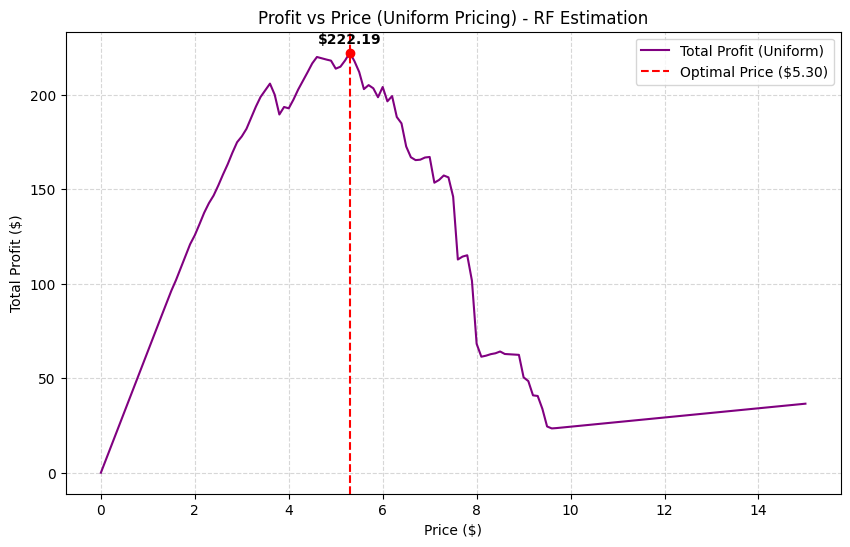

In [28]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- Parameters ----------------
S_A = 45
S_B = 45

# Current Context features
market_sentiment = 1.0
zone_specific_A = 2.1
zone_specific_B = 1.0
competitor_prices_A = 4.0
competitor_prices_B = 6.0

# ---------------- Helper Functions ----------------

def get_demand_A_rf(price):
    # Create a DataFrame with the exact feature names used in training
    # features_A = ["price_A", "market_sentiment", "zone_specific_A", "competitor_prices_A"]
    X_pred = pd.DataFrame({
        "price_A": [price],
        "market_sentiment": [market_sentiment],
        "zone_specific_A": [zone_specific_A],
        "competitor_prices_A": [competitor_prices_A]
    })
    # rf_A is the trained model from previous cell
    predicted_demand = rf_A.predict(X_pred)[0]
    return max(0, predicted_demand)

def get_demand_B_rf(price):
    # features_B = ["price_B", "market_sentiment", "zone_specific_B", "competitor_prices_B"]
    X_pred = pd.DataFrame({
        "price_B": [price],
        "market_sentiment": [market_sentiment],
        "zone_specific_B": [zone_specific_B],
        "competitor_prices_B": [competitor_prices_B]
    })
    predicted_demand = rf_B.predict(X_pred)[0]
    return max(0, predicted_demand)

def calculate_profit(price):
    d_A = get_demand_A_rf(price)
    sales_A = min(d_A, S_A)

    d_B = get_demand_B_rf(price)
    sales_B = min(d_B, S_B)
    return price * sales_A + price * sales_B

# ---------------- Optimization (Grid Search) ----------------
# Since Random Forests are not smooth, we use a fine grid search instead of calculus.
price_grid = np.linspace(0, 15, 151) # Check every $0.10 from $0 to $15

# 1. Spatial Pricing (Optimize independently)
best_pA = 0
max_rev_A = 0
for p in price_grid:
    d = get_demand_A_rf(p)
    rev = p * min(d, S_A)
    if rev > max_rev_A:
        max_rev_A = rev
        best_pA = p

best_pB = 0
max_rev_B = 0
for p in price_grid:
    d = get_demand_B_rf(p)
    rev = p * min(d, S_B)
    if rev > max_rev_B:
        max_rev_B = rev
        best_pB = p


print(f"Optimal Price Zone A: ${best_pA:.2f}, Demand A at optimal price: {get_demand_A_rf(best_pA):.2f}, Optimal Revenue Zone A: ${max_rev_A:.2f}")
print(f"Optimal Price Zone B: ${best_pB:.2f}, Demand B at optimal price: {get_demand_B_rf(best_pB):.2f}, Optimal Revenue Zone B: ${max_rev_B:.2f}")
print(f"Total Profit: ${max_rev_A + max_rev_B:.2f}")

# 2. Uniform Pricing (Optimize pA = pB = p)
best_p_uniform = 0
max_rev_uniform = 0
uniform_profits = []

for p in price_grid:
    prof = calculate_profit(p)
    uniform_profits.append(prof)
    if prof > max_rev_uniform:
        max_rev_uniform = prof
        best_p_uniform = p

print(f"Optimal Price: ${best_p_uniform:.2f}, Demand at optimal price: {get_demand_A_rf(best_p_uniform)+get_demand_B_rf(best_p_uniform):.2f}, Total Profit: ${max_rev_uniform:.2f}")

# ---------------- Plotting ----------------
plt.figure(figsize=(10, 6))
plt.plot(price_grid, uniform_profits, label='Total Profit (Uniform)', color='purple')
plt.axvline(x=best_p_uniform, color='red', linestyle='--', label=f'Optimal Price (${best_p_uniform:.2f})')
plt.scatter([best_p_uniform], [max_rev_uniform], color='red', zorder=5)
plt.text(best_p_uniform, max_rev_uniform + 5, f"${max_rev_uniform:.2f}", ha='center', color='black', fontdict={'weight': 'bold'})

plt.title('Profit vs Price (Uniform Pricing) - RF Estimation')
plt.xlabel('Price ($)')
plt.ylabel('Total Profit ($)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### 3. Challenge

Here are three main challenges when scaling this independent estimation + optimization approach to many zones:

1. Optimization Complexity (The "Curse of Dimensionality")
In the current approach, we used grid search to check prices. This works fine for 1 or 2 zones. However, if you have $N$ zones, the search space grows exponentially ($PriceGridSize^N$). Which is computationally impossible to solve with brute force or simple grid search. We would need sophisticated solvers.

2. Modeling Cross-Zone Spillover Effects
The current code trains `rf_A` and `rf_B` independently, assuming Zone A's price doesn't affect Zone B. In a dense city with many zones, if Zone A is expensive, users might walk to Zone B. Demand in Zone $i$ depends on prices in Zone $j, k, l...$. Modeling rugrously these interactions requires estimating $N \times N$ cross-elasticities. A simple "one model per zone" approach fails to capture these complex substitution patterns.

3. Data Sparsity
To train a Random Forest for every single zone, we need sufficient historical data for **each** zone covering various price points. In a system with thousands of zones, many zones (e.g., quiet suburbs) will have very sparse data (few rides). Machine learning models like Random Forest perform poorly on sparse data. We might end up with unreliable demand curves for low-traffic zones, leading to incorrect pricing.


